In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage
sys.path.append("../src")
import exlib
from exlib.datasets.chestxdet import ChestXDetDataset, ChestXDetModel, ChestXDetMetric

## Overview
* The objective is to predict the **pathology** regions (atelectasis, calcification, etc. Total 13).
* The higher-level features are the anatomical **structures** (left clavicle, right clavicle, etc. Total 14).

In [2]:
dataset = ChestXDetDataset(split="test", image_size=256)
pathols_model = ChestXDetModel.from_pretrained("BrachioLab/chestxdet_pathols").eval()

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

## Dataset samples and model predictions
Primary task: predict where the pathologies are

In [3]:
torch.manual_seed(105)
for i in torch.randperm(len(dataset)):
    sample = dataset[i.item()]
    image, pathols, structs = sample["image"], sample["pathols"], sample["structs"]
    if pathols.sum() > 0 and structs.sum() > 0:
        break

with torch.no_grad():
    pathols_pred = (pathols_model(image[None,...]).logits[0] > 0).long()

<Figure size 640x480 with 0 Axes>

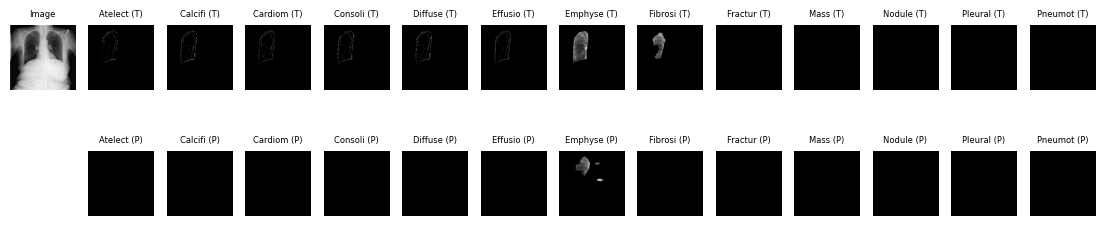

In [4]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"pathol{i}t" for i in range(13)]),
    (["."] + [f"pathol{i}p" for i in range(13)]),
], figsize=(14,3))

for _, a in ax.items(): a.set_axis_off()
ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")

pathol_titles = ChestXDetDataset.pathology_names
struct_titles = ChestXDetDataset.structure_names
ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
fs = 6
ax["image"].set_title("Image", fontsize=fs)

for i in range(13):
    mask_t = pathols[i].unsqueeze(0)
    mask_p = (pathols_pred[i]).unsqueeze(0)
    ax[f"pathol{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"pathol{i}p"].imshow(((image * mask_p).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"pathol{i}t"].set_title(f"{pathol_titles[i][:7]} (T)", fontsize=fs)
    ax[f"pathol{i}p"].set_title(f"{pathol_titles[i][:7]} (P)", fontsize=fs)

Unfortunately, our pre-trained models aren't so good at pathology segmentation, but maybe you can do better!

## Expert-specified higher-level features: anatomical structures
Identifying where key structures are is important!

<Figure size 640x480 with 0 Axes>

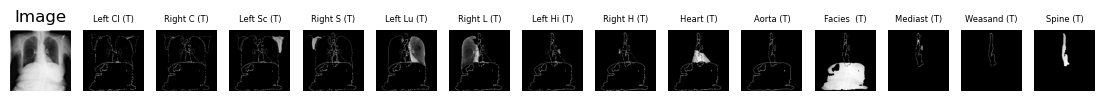

In [5]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"struct{i}t" for i in range(14)]),
], figsize=(14,2))

for _, a in ax.items(): a.set_axis_off()
struct_titles = ChestXDetDataset.structure_names


ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
ax["image"].set_title("Image")

for i in range(14):
    mask_t = structs[i].unsqueeze(0)
    ax[f"struct{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}t"].set_title(f"{struct_titles[i][:7]} (T)", fontsize=fs)

## How well are the higher-level feature alignments?
Let's define two different high-level feature extractors for comparison:
* gridding
* quickshift

In [6]:
class GridHighLevelFeatures(nn.Module):
    # Let's assume image is 256x256 and make 32-wide grids (i.e., 8x8 partitions)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        N, _, _, _ = x.shape
        mask_small = torch.tensor(range(8*8)).view(1,1,8,8).repeat(N,1,1,1)
        mask_big = F.interpolate(mask_small.float(), scale_factor=32).round().long()
        return mask_big.view(N,256,256)

In [7]:
class QuickShiftFeatures(nn.Module):
    # Use quickshift to perform image segmentation
    def __init__(self, kernel_size=10, max_dist=20, sigma=5, max_segs=40):
        super().__init__()
        self.kernel_size = kernel_size
        self.max_dist = max_dist
        self.sigma = sigma
        self.max_segs = max_segs

    def quickshift(self, image):
        # image is (C,H,W)
        C, _, _ = image.shape
        if C == 1:
            image = image.repeat(3,1,1)
        image_np = image.numpy().transpose(1,2,0)
        segs = skimage.segmentation.quickshift(image_np, kernel_size=self.kernel_size, max_dist=self.max_dist, sigma=self.sigma)
        segs = torch.tensor(segs)
        segs[segs >= self.max_segs] = self.max_segs - 1
        return segs.long() # (H,W) of integers

    def forward(self, x):
        # x: (N,C,H,W)
        segs = torch.stack([self.quickshift(xi.cpu()) for xi in x]) # (N,H,W)
        return segs.to(x.device)

In [8]:
metric = ChestXDetMetric()
grid_extractor = GridHighLevelFeatures()
qshift_extractor = QuickShiftFeatures()
torch.manual_seed(1234)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
grid_scores, qshift_scores = [], []
for i, item in enumerate(tqdm(dataloader)):
    image = item["image"]
    with torch.no_grad():
        structs_masks = item["structs"]
        grid_masks = F.one_hot(grid_extractor(image)).permute(0,3,1,2)
        qshift_masks = F.one_hot(qshift_extractor(image)).permute(0,3,1,2)
        
        grid_score = metric(grid_masks, structs_masks) # (N,H,W)
        qshift_score = metric(qshift_masks, structs_masks)
        grid_scores.append(grid_score.mean(dim=(1,2)))
        qshift_scores.append(qshift_score.mean(dim=(1,2)))
    if i > 10:
        break

grid_scores = torch.cat(grid_scores)
qshift_scores = torch.cat(qshift_scores)

print(f"Avg alignment of grid features: {grid_scores.mean():.4f}")
print(f"Avg alignment of qshift features: {qshift_scores.mean():.4f}")

  8%|▊         | 11/139 [02:01<23:34, 11.05s/it]

Avg alignment of grid features: 0.0529
Avg alignment of qshift features: 0.2092
